In [12]:
from collections import defaultdict

import os
import sys
import pymongo
import pandas as pd
import numpy as np
import math

import pandas_bokeh

pandas_bokeh.output_notebook()
from typing import List

from pprint import pprint
from badger_utils.sacred import SacredReader, SacredConfigFactory
import matplotlib.pyplot as plt

project_path = os.path.abspath(os.path.join('..', '..'))
if project_path not in sys.path:
    sys.path.append(project_path)

from badger_utils.view.result_utils import dict_omit_keys, dict_to_tuple, tuple_to_dict, find_common_keys, group_dicts

observer = SacredConfigFactory.local().create_mongo_observer()


def load_metrics(run_ids: List) -> pd.DataFrame:
    runs = observer.metrics.find({'run_id': {'$in': run_ids}})
    df = pd.DataFrame()
    for run in runs:
        steps, values = run['steps'], run['values']
        df = df.join(pd.DataFrame(values, index=steps, columns=[run['run_id']]), how='outer')
    return df


def plot_df(df: pd.DataFrame, bokeh=False, **kwargs):
    if 'logy' not in kwargs:
        kwargs['logy'] = True
    if bokeh:
        if 'xtickx' not in kwargs:
            kwargs['xticks'] = range(0, df.index.max(), 500)
        return df.plot_bokeh(figsize=(1600, 600), **kwargs)
    else:
        if 'legend' not in kwargs:
            kwargs['legend'] = False
        return df.plot(figsize=(20, 6), **kwargs)


def plot_hist(df: pd.DataFrame, bin_size=1000, bokeh=False, **kwargs):
    if 'bins' not in kwargs:
        kwargs['bins'] = range(0, df.max()[0] + bin_size, bin_size)
    plot = df.plot_bokeh if bokeh else df.plot
    plot.hist(**kwargs)


def df_avg(df: pd.DataFrame, window=100) -> pd.DataFrame:
    return df.rolling(window=window).mean()


def df_filter_solutions(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    return df.loc[:, df_avg(df).min() < threshold]


def scan_results_for_success(df: pd.DataFrame, show_ids: bool = False):
    total_runs = len(df.columns)
    print(f'Total runs: {total_runs}')

    for v in [0.5, 0.1, 0.01, 0.001]:
        f = df_filter_solutions(df, v)
        count = len(f.columns)
        ids = f' - {[i for i in f.columns]}' if show_ids else ''
        print(f'Min value: {v}: {count} runs found - {count / total_runs * 100:0.1f}%' + ids)
    #     plot_df(df_avg(f)[::10], bokeh=True)


def analyze_results(df: pd.DataFrame, threshold: float):
    f = df_filter_solutions(df, threshold)
    # plot loss
    plot_df(df_avg(f)[::10], bokeh=True, title="loss", xlabel="epoch", ylabel="loss")
    # plot first solution epoch histogram
    plot_hist(pd.DataFrame((f < 0.01).idxmax()), bokeh=True, title="First solution found", xlabel="epoch",
              ylabel="# of runs")
    # plot solution stability
    plot_df(df_avg(f[f < threshold].count(axis=1))[::10], bokeh=True, title="# of solutions", xlabel="epoch",
            ylabel="# of runs", logy=False)

Loading BokehJS ...

In [ ]:
df = load_metrics(list(range(88, 182)))  # 3 inputs
# df = load_metrics(list(range(88, 182)))[:6000] # 3 inputs, just 6000 epochs
# df = load_metrics(list(range(185, 229))) # 5 inputs
# df.rolling(window=100).mean().plot(legend=False, figsize=(20, 6), logy=True)
df = load_metrics(list(range(434, 464)))
plot_df(df_avg(df))

In [ ]:
scan_results_for_success(df)
threshold = 0.01
analyze_results(df, 0.01)

In [ ]:
# df = load_metrics(list(range(88, 182))) # 3 inputs
dfs = {
#     '3 inputs_full': load_metrics(list(range(88, 182))),  # 3 inputs, just 6000 epochs
#     '3 inputs': load_metrics(list(range(88, 182)))[:6000],  # 3 inputs, just 6000 epochs
#     '5 inputs': load_metrics(list(range(185, 229))),  # 5 inputs
#     '5 inputs - bs: 64': load_metrics(list(range(240, 275)))  # 5 inputs
   '3 inputs - fixed delay bs: 64': load_metrics(list(range(334, 408))),
#     '3 inputs - random values': load_metrics(list(range(434, 464)))    
    
}
threshold = 0.01
for name, df in dfs.items():
    print(f'Run {name}')
    scan_results_for_success(df)
    analyze_results(df, threshold)

In [ ]:
import io
import torch
from gridfs import GridFS
from badger_utils.sacred import SacredReader, SacredConfigFactory

observer = SacredConfigFactory.local().create_mongo_observer()

class GridFSReader:

    def __init__(self, fs: GridFS):
        self.fs = fs

    def _artifact_prefix(self, run_id: int) -> str:
        return f'artifact://runs/{run_id}/'
    
    def list_artifacts(self, run_id: int):
        prefix = self._artifact_prefix(run_id)
        files = self.fs.find({'filename': {'$regex': prefix}})
        return [f.name[len(prefix):] for f in files]

    def read_artifact(self, run_id: int, filename: str) -> bytes:
        file = observer.fs.find({'filename': f'{self._artifact_prefix(run_id)}{filename}'})[0]        
        return file.read()

reader = GridFSReader(observer.fs)                                 
run_id = 83
                                 
files = reader.list_artifacts(run_id)
print(f'Files: \n{files}')                                 
item = torch.load(io.BytesIO(reader.read_artifact(run_id,  'agent_ep_1000.model')))                                 
print(type(item))

In [ ]:
experiment_id = 1
sr = SacredReader(experiment_id, SacredConfigFactory.local())
print(sr.config)

sr.run_data

In [11]:
def analyze_runs(observer, run_ids: List[int]):
    runs = observer.runs.find({ '_id': { '$in': run_ids}}, {'_id': 1, 'config': 1})
    items = list(runs)
    common_keys = find_common_keys(items, lambda x: x['config'])
    result = group_dicts(items, lambda x: dict_omit_keys(x['config'], set(common_keys) | {'seed'}), lambda x: x['_id'])
    return common_keys, result

analyze_runs(observer, list(range(1960,1962)))

({'attention_beta': 5,
  'attention_operation': 'euclidean_distance',
  'batch_size': 32,
  'epochs': 500000,
  'hidden_state_size': 16,
  'id_size': 8,
  'image_save_period': 10000,
  'key_size': 2,
  'learning_rate': 0.001,
  'learning_rollout_steps_clip': 6,
  'n_experts': 3,
  'rollout_size': 16,
  'save_period': 1000,
  'task_size': 3,
  'value_size': 9},
 defaultdict(list,
             {(('learning_exp_decay', 2.0),
               ('onehot_expert_ids', True)): [1960],
              (('learning_exp_decay', 0.0),
               ('onehot_expert_ids', False)): [1961]}))

In [ ]:
print('Common params:')
pprint(common_keys)
# for k,v in common_keys.items():
#     {[f"k: v\n" in k,v in common_keys.items()]}
for k, v in result.items():
    print(f'{tuple_to_dict(k)}: {len(v)}')
    df = load_metrics(v)
    scan_results_for_success(df)
#     analyze_results(df, 1e-3)

Common params:
{'attention_operation': "{'py/reduce': [{'py/type': "
                        "'badger.models.attention.attention.AttentionOperation'}, "
                        "{'py/tuple': [3]}, None, None, None]}",
 'batch_size': 64,
 'hidden_state_size': 16,
 'id_size': 63,
 'ignore_error_start_steps': 5,
 'image_save_period': 100,
 'learning_rate': 0.001,
 'save_period': 100,
 'training_reset_targets_period': -1,
 'training_steps': 2,
 'training_substeps': 1,
 'value_size': 64}


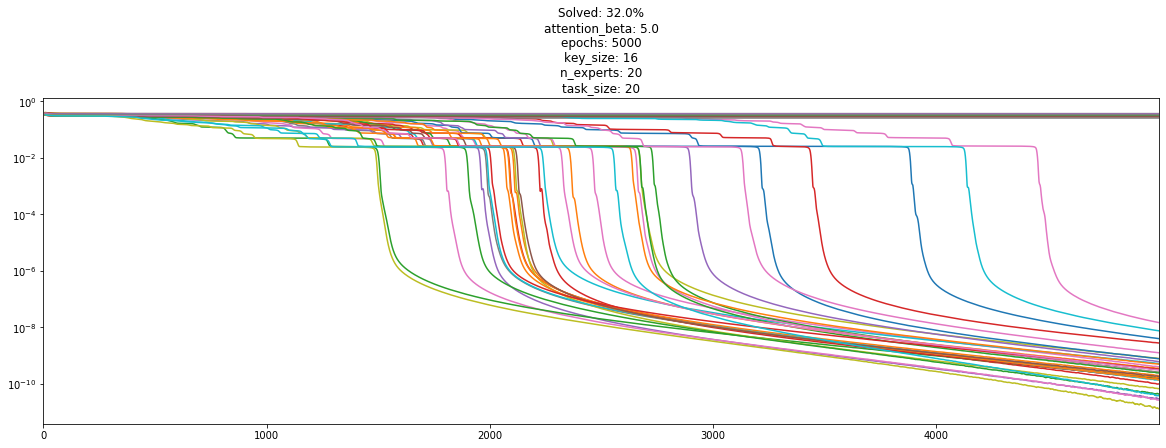

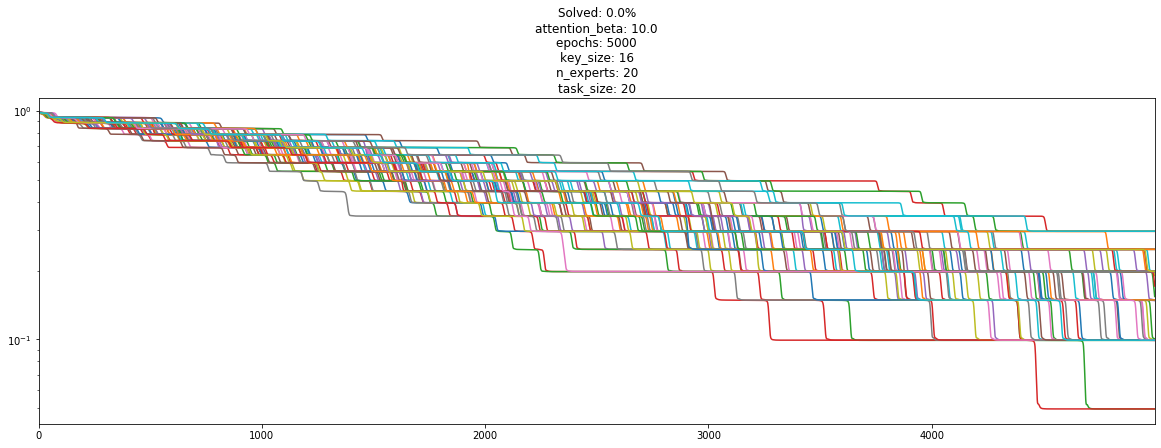

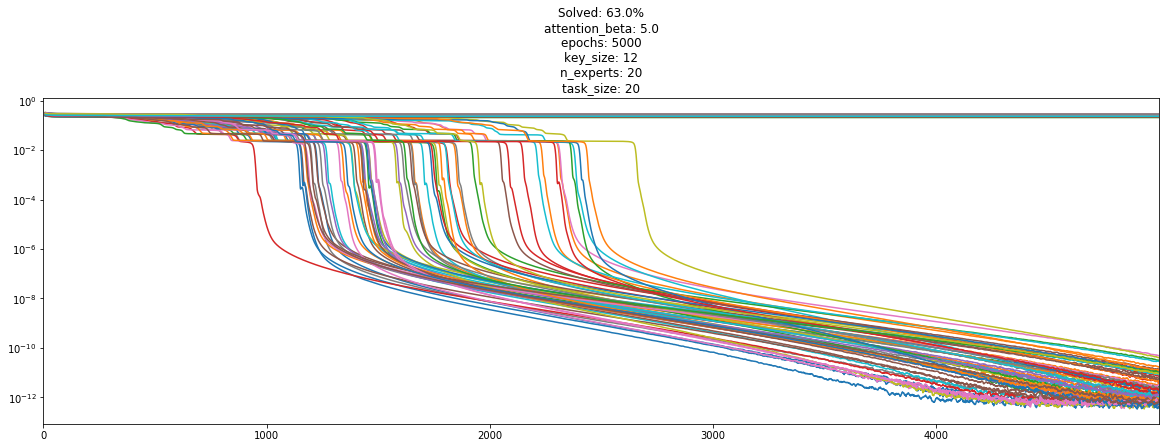

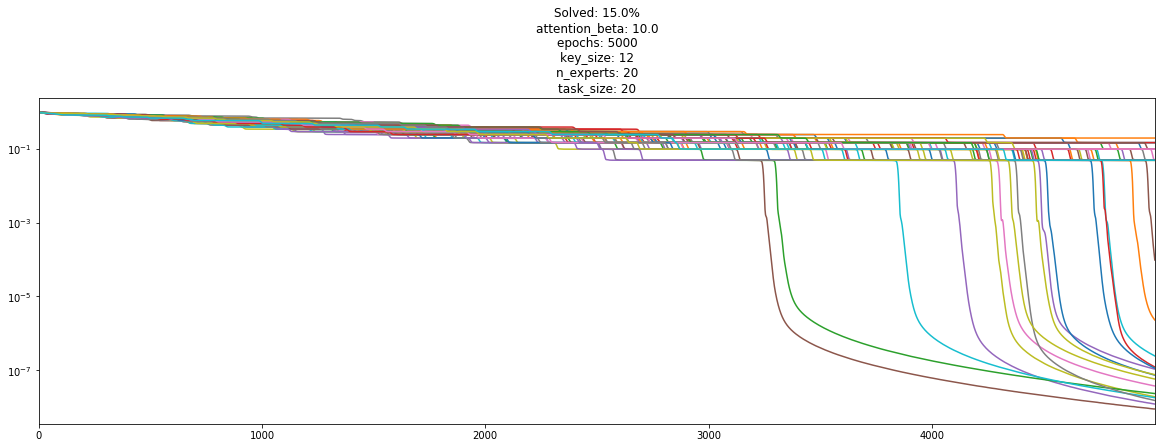

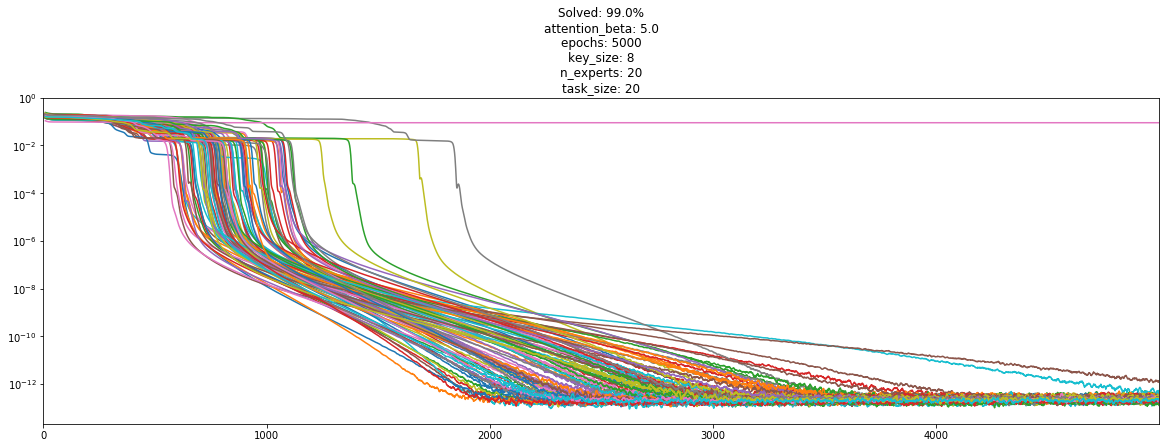

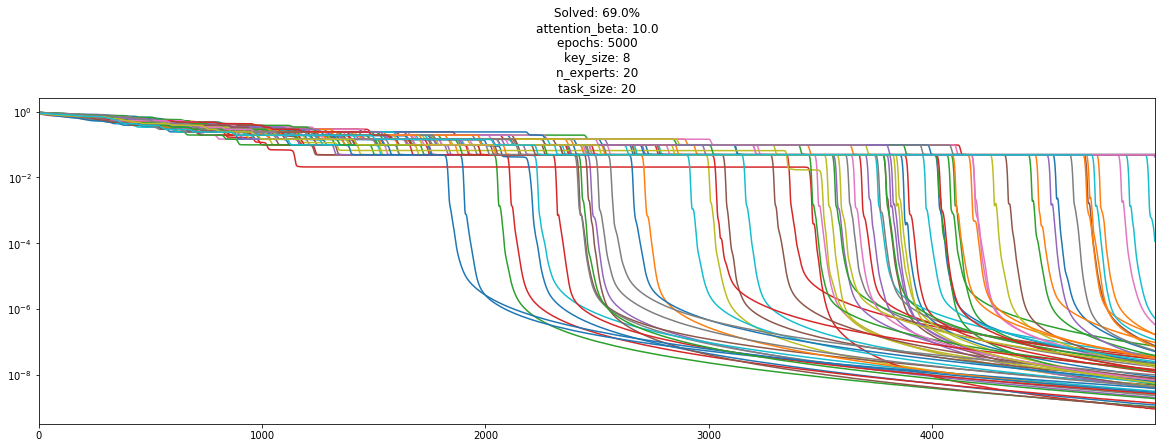

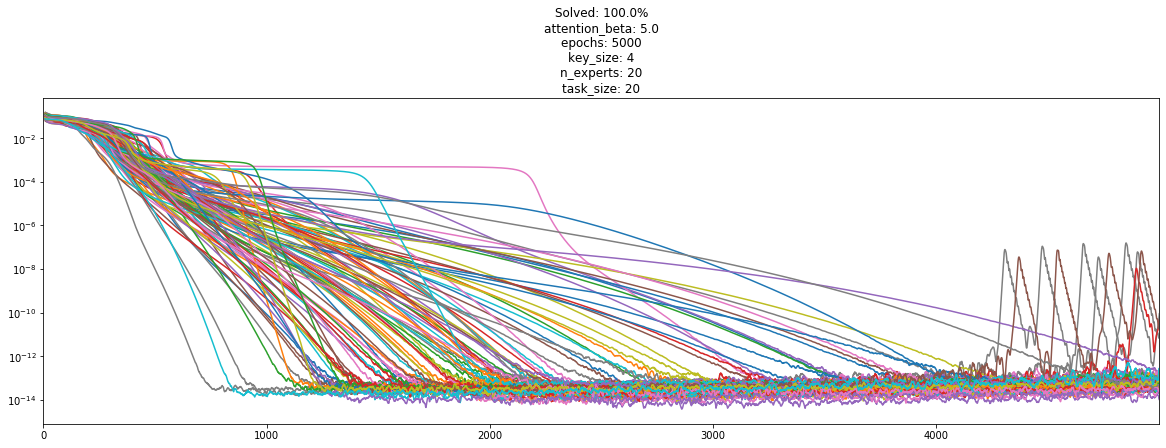

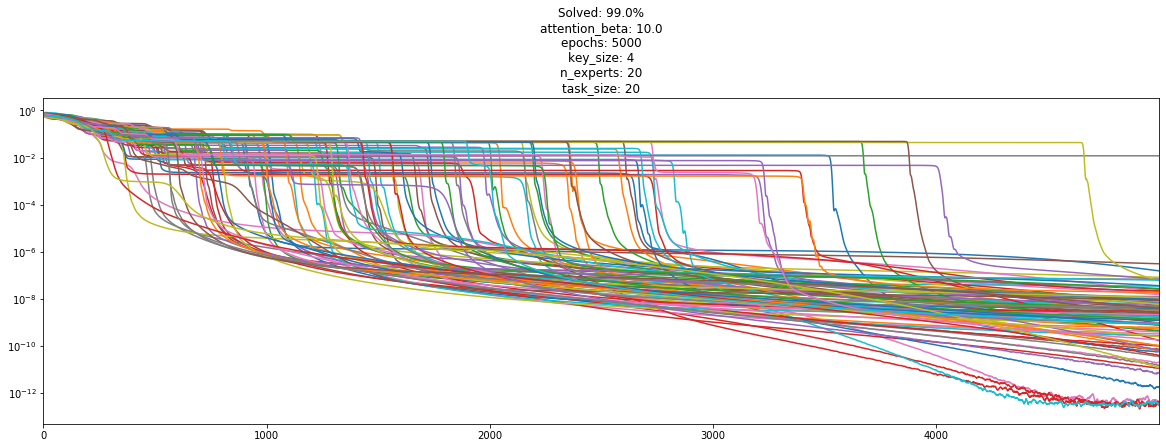

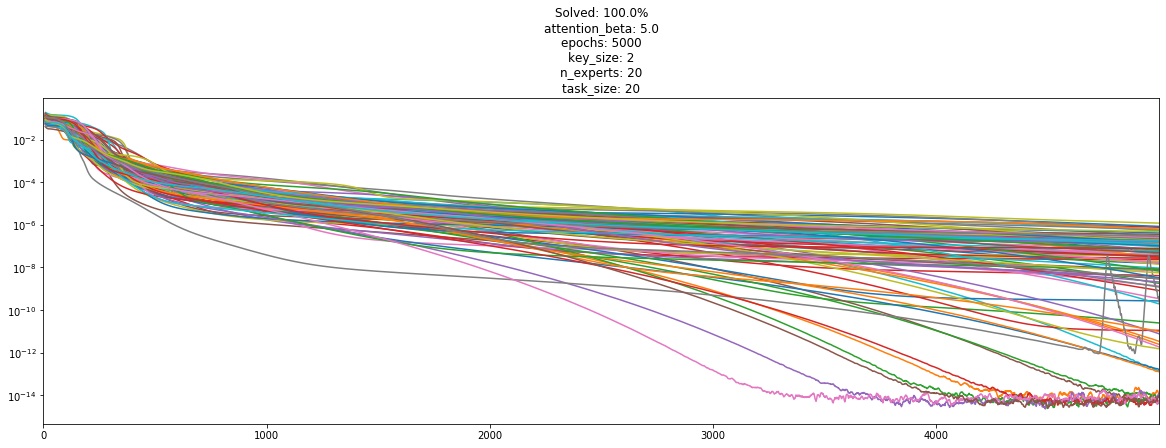

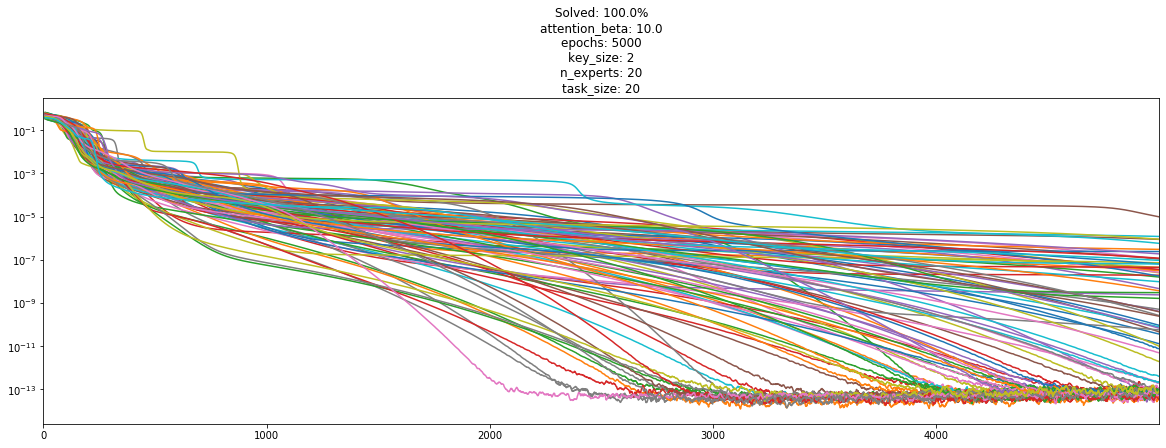

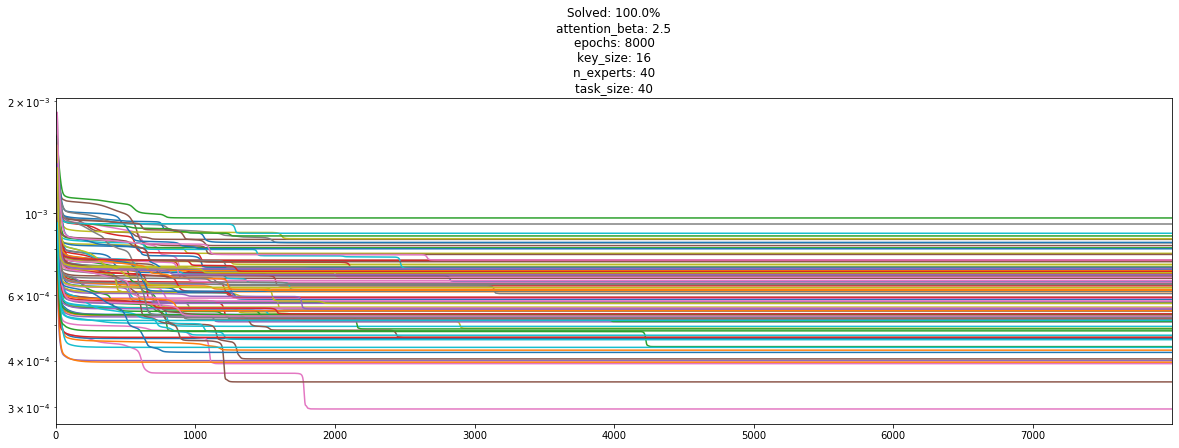

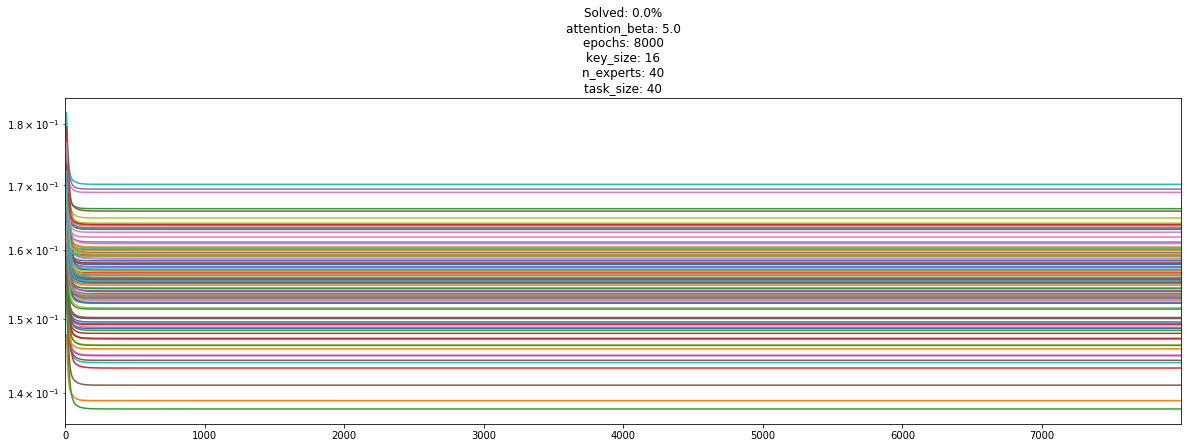

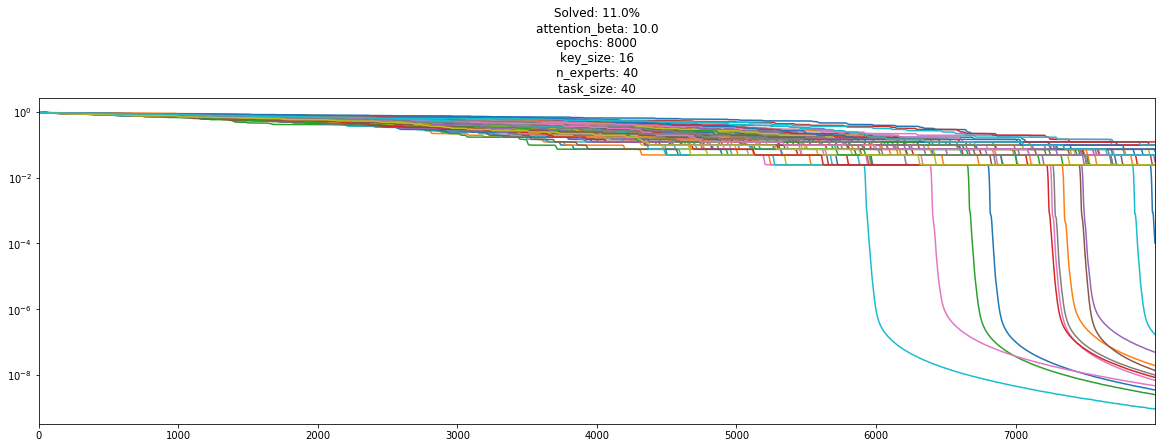

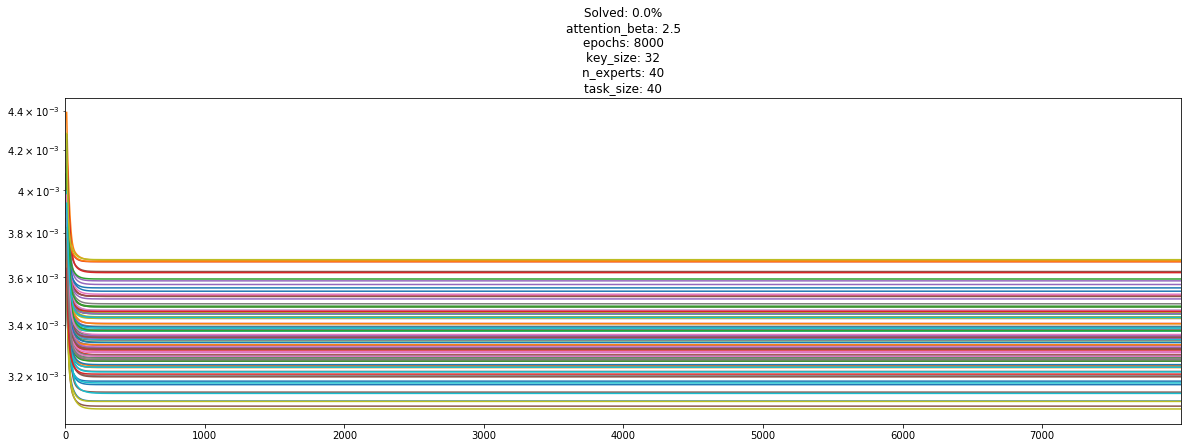

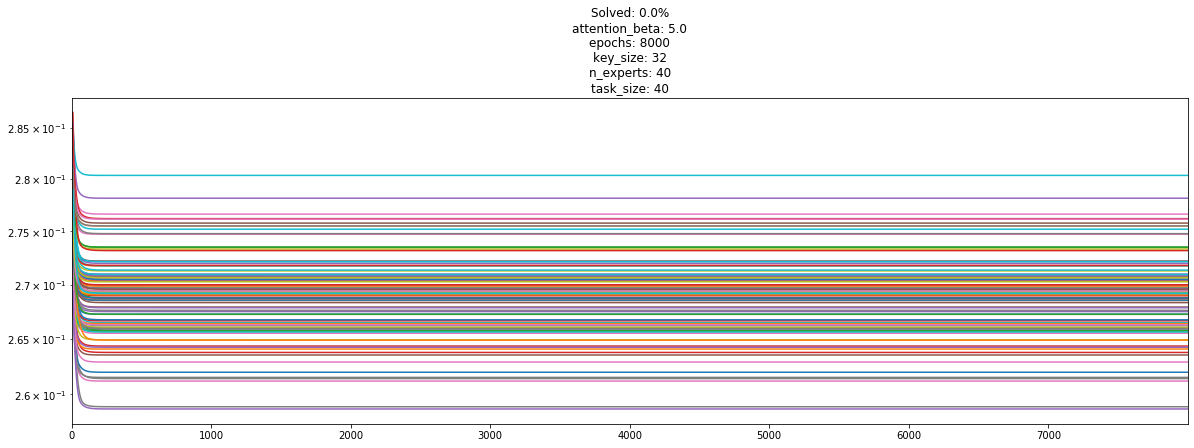

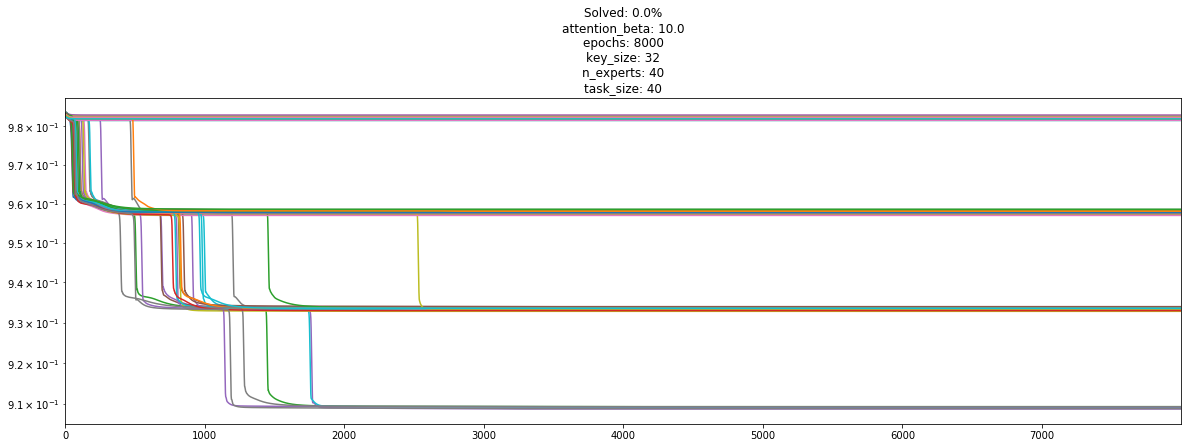

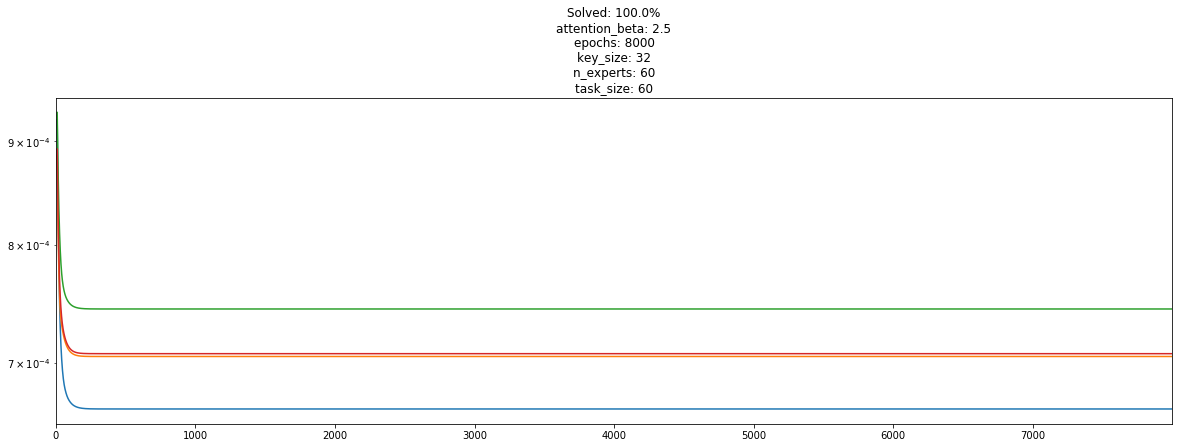

In [2]:
runs = observer.runs.find({
    '$and': [
        {
            '_id': {
                '$gte': 218
            }
        }, {
            '_id': {
                '$lte': 1821
            }
        }
    ]
}, {'_id': 1, 'config': 1})


items = list(runs[:])
common_keys = find_common_keys(items, lambda x: x['config'])
result = group_dicts(items, lambda x: dict_omit_keys(x['config'], set(common_keys) | {'seed'}), lambda x: x['_id'])

print('Common params:')
pprint(common_keys)
# for k,v in common_keys.items():
#     {[f"k: v\n" in k,v in common_keys.items()]}
# count = 1
plots = []
for k, v in result.items():
#     print(f'{tuple_to_dict(k)}: {len(v)}')
    df = load_metrics(v)
    solutions_found = len(df_filter_solutions(df, 1e-3).columns)
    config = '\n'.join([f'{a}: {b}' for a,b in k])
    a = plot_df(df_avg(df, 10), title=f'Solved: {float(solutions_found)/len(v)*100}%\n{config}')    
#     a.get_figure().savefig(f'fig_{count}.png', bbox_inches = "tight")
    plots.append(a)
#     count += 1

[[-0.689 -0.232]]
[[-0.542 -0.276]
 [-0.74  -0.314]]


array([[-0.689, -0.232],
       [-0.542, -0.276],
       [-0.74 , -0.314]], dtype=float32)

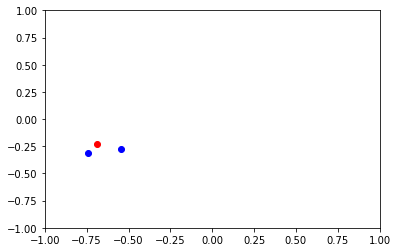

In [145]:
experiment_id = 1864
epoch = 400
sr = SacredReader(experiment_id, SacredConfigFactory.local())
# print(sr.config)
t = sr.load_tensor('tensors.pt', epoch)[-1]['keys_2'].detach().cpu().numpy()
# sr.list_artifacts()
index = t[0:1]
expert = t[1:3]
np.set_printoptions(precision=3, suppress=True)
print(index)
print(expert)
data = t
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(index[:, 0], index[:, 1], color='red')
plt.scatter(expert[:, 0], expert[:, 1], color='blue')

# print(index)
# print(expert)
t
# 49,87

In [64]:
d = index[0] - expert[0]
math.sqrt((d*d).sum())

0.15325461030733747

In [161]:
from torch import Tensor
import torch.nn.functional as F
import torch
def pt(t, name):
    print(f'{name}: {t.shape}')
    print(t)
def _dot_product(a: Tensor, b: Tensor) -> Tensor:
    return torch.sum(a * b, 2)

def _euclidean_distance_squared(k: Tensor, q: Tensor) -> Tensor:
    return _dot_product(k, k) - 2 * _dot_product(k, q) + _dot_product(q, q)
    
def pot(data):
    data = torch.tensor(data)
#     k = torch.cat([data[0:2], torch.tensor([[x, y]], dtype=torch.float)], dim=0)
#     k = torch.cat([data[0:2], torch.tensor([[x, y]], dtype=torch.float)], dim=0)
    
#     pt(k, 'k')
    k = data.unsqueeze(1)
    q = data[0:1].unsqueeze(0)
    
    eps = 1e-4
    beta = 7.0
#     pt(q, 'q')
    distance = _euclidean_distance_squared(k,q) + eps
    
    weights = (distance.pow(0.5) + 1).reciprocal()
    weights = F.softmax(weights * beta, dim=0).squeeze()
#     pt(weights, 'weights')
    value = torch.sum(weights * torch.tensor([1.0, 0, -1])).item()
    return value

pt(data, 'data')
pot(data)

data: (3, 2)
[[-0.689 -0.232]
 [-0.542 -0.276]
 [-0.74  -0.314]]


2.384185791015625e-07

(80, 80)


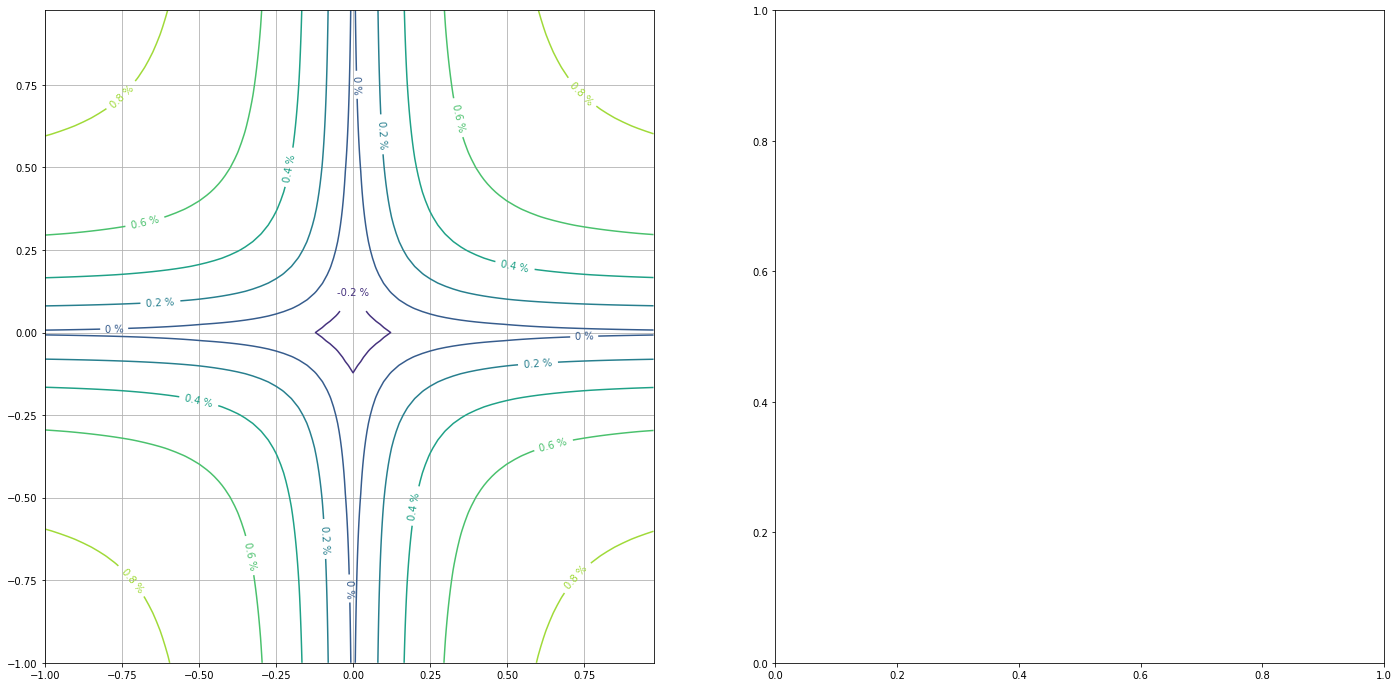

In [166]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(24,12))

def plot_c(ax, data):
    delta = 0.025
    x = np.arange(-1.0, 1.0, delta)
    y = np.arange(-1.0, 1.0, delta)
    X, Y = np.meshgrid(x, y)

    Z = (Z1 - Z2) * 2
    print(Z.shape)
    for xi, x_val in enumerate(x):
        for yi, y_val in enumerate(y):
            
            Z[yi,xi] = pot(np.array([[0, 0], [y_val, 0], [x_val, 0]]))

    class nf(float):
        def __repr__(self):
            s = f'{self:.1f}'
            return f'{self:.0f}' if s[-1] == '0' else s


    # Basic contour plot
    CS = ax.contour(X, Y, Z)

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r \%%'
    else:
        fmt = '%r %%'

    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.grid()

plot_c(axes[0], data)

(80, 80)
(80, 80)


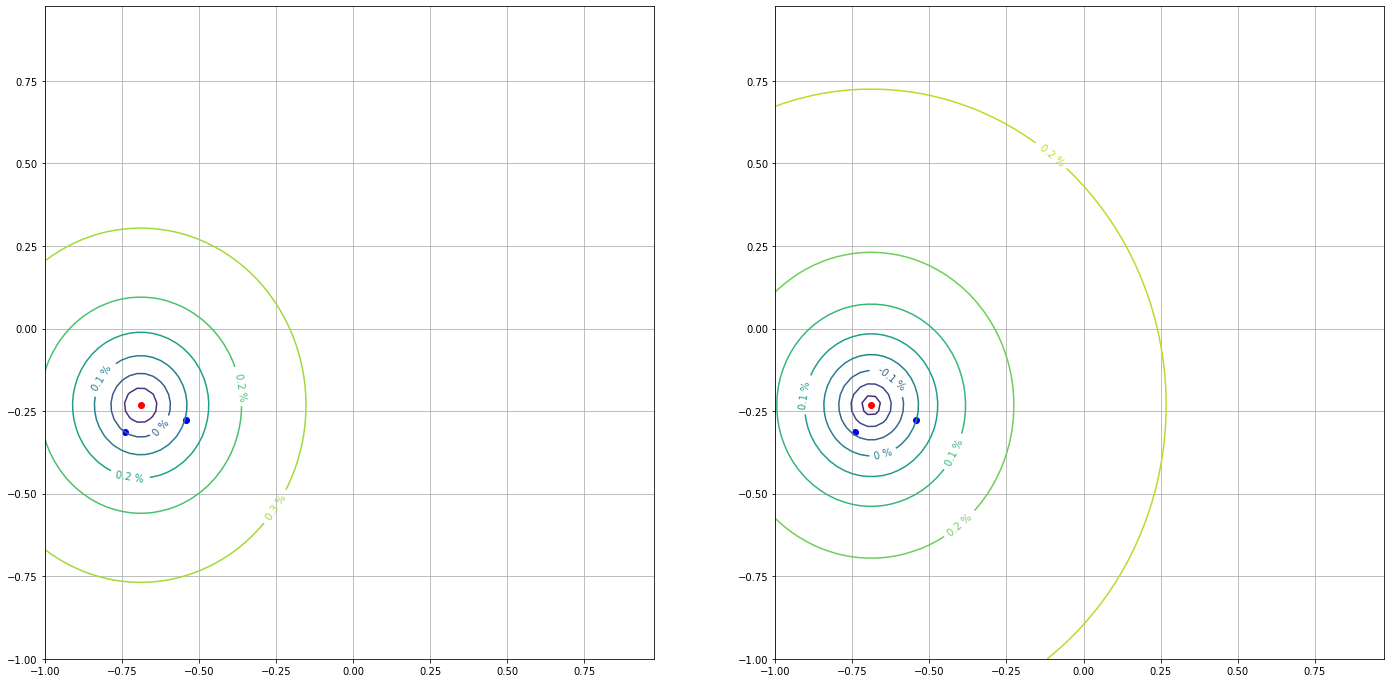

In [162]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(24,12))

def plot_c(ax, data):
    delta = 0.025
    x = np.arange(-1.0, 1.0, delta)
    y = np.arange(-1.0, 1.0, delta)
    X, Y = np.meshgrid(x, y)

    Z = (Z1 - Z2) * 2
    print(Z.shape)
    for xi, x_val in enumerate(x):
        for yi, y_val in enumerate(y):
            
            Z[yi,xi] = pot(np.array([data[0], data[1], [x_val, y_val]]))

    class nf(float):
        def __repr__(self):
            s = f'{self:.1f}'
            return f'{self:.0f}' if s[-1] == '0' else s


    # Basic contour plot
    CS = ax.contour(X, Y, Z)

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r \%%'
    else:
        fmt = '%r %%'

    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.grid()
    ax.scatter(index[:, 0], index[:, 1], color='red')
    ax.scatter(expert[:, 0], expert[:, 1], color='blue')

plot_c(axes[0], data)
plot_c(axes[1], np.array([data[0], data[2], data[1]]))

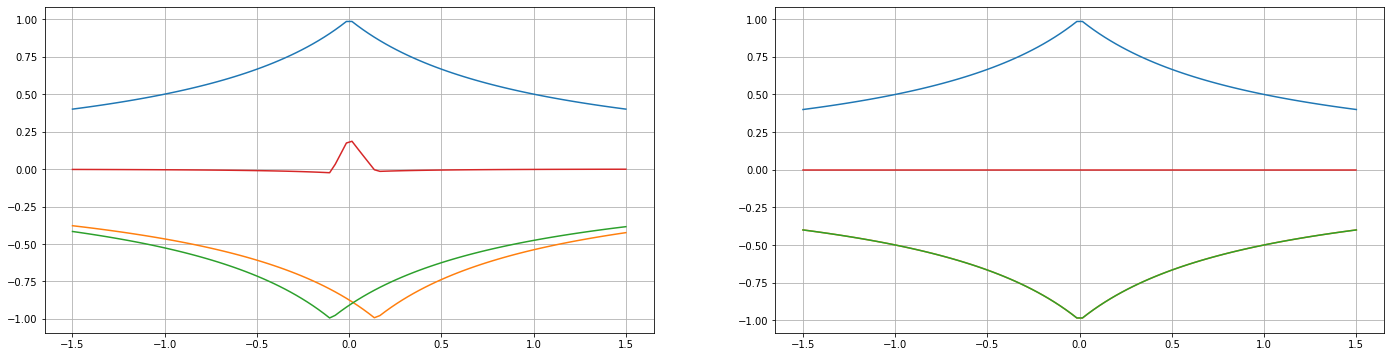

In [67]:
import numpy as np

def plot_potential(d1, d2, ax):
    p = 1.0
    
    x = np.linspace(-1.5, 1.5, 100)
    y = 1/(1+abs(x)**p)
    z1 = -1/(1+(abs(d1-x))**p)
    z2 = -1/(1+(abs(d2-x))**p)
#     w, w1, w2 = (0.5, .22, .28)
    w, w1, w2 = (2, 0.8, 1.2)
    ax.plot(x, y)
    ax.plot(x, z1)
    ax.plot(x, z2)
    ax.plot(x, w*y + w1*z1 + w2*z2)
    ax.grid()

distances = [0]
fig, axes = plt.subplots(1, 2, figsize=(24,6))
# for i, d in enumerate(distances):
plot_potential(0.144, -0.10, axes[0])
# plot_potential(1.044, -1.0, axes[1])
plot_potential(0.0, -0.0, axes[1])

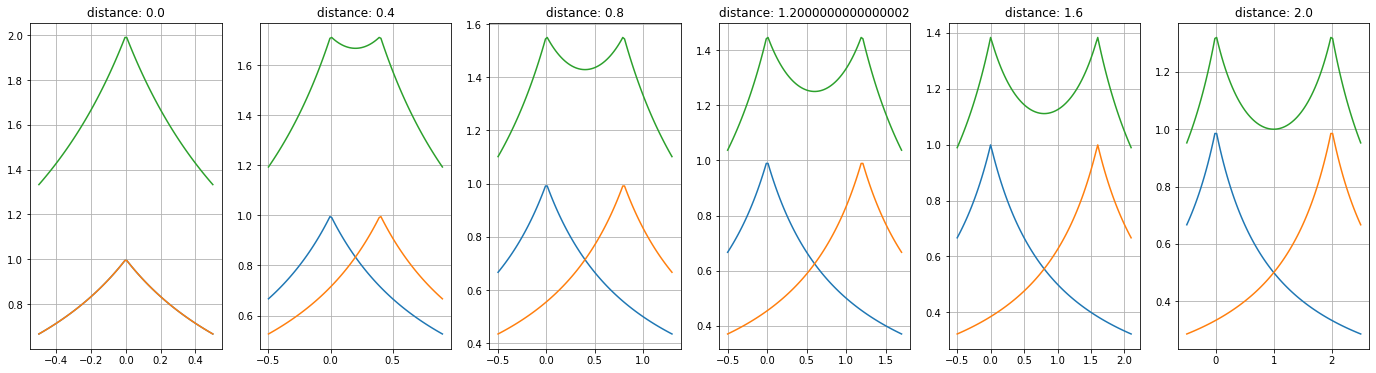

In [38]:
import numpy as np

def plot_potential(distance, ax):
    p = 1
    
    x = np.linspace(-0.5, distance+0.5, 100)
    y = 1/(1+abs(x)**p)
    z = 1/(1+(abs(distance-x))**p)
    ax.plot(x, y)
    ax.plot(x, z)
    ax.plot(x, y+z)
    ax.grid()
    ax.set_title(f'distance: {distance}')

distances = np.linspace(0, 2, 6)
fig, axes = plt.subplots(1, len(distances), figsize=(24,6))
for i, d in enumerate(distances):
    plot_potential(d, axes[i])

In [32]:
experiment_id = 1883
epoch = 3000
sr = SacredReader(experiment_id, SacredConfigFactory.local())
# print(sr.config)
t = sr.load_tensor('tensors.pt', epoch)[-1]['weights_2'].detach().cpu()
# sr.list_artifacts()
t

File "/home/phlubucek/prog/attention-badger/experiments/search_task/data/loaded_from_sacred/artifacts-1883/tensors_ep_3000.pt" not found locally..


tensor([[0.0928, 0.0006, 0.0037,  ..., 0.0023, 0.0012, 0.0006],
        [0.0007, 0.0849, 0.0009,  ..., 0.0007, 0.0022, 0.0180],
        [0.0033, 0.0007, 0.1063,  ..., 0.0055, 0.0013, 0.0007],
        ...,
        [0.0012, 0.0008, 0.0033,  ..., 0.0042, 0.0007, 0.0009],
        [0.0030, 0.0013, 0.0065,  ..., 0.0018, 0.0037, 0.0010],
        [0.0006, 0.0179, 0.0008,  ..., 0.0007, 0.0014, 0.0841]])

In [34]:
b = t[200:] > 0.06
b.sum(dim=0)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1])

In [84]:
# runs = observer.runs.find({ 
#         "start_time" : {
#             "$gt" : "2019-11-28T08:55:37.028+0000"
#         }
#     }, {'_id': 1, 'config': 1}).sort([('_id', pymongo.DESCENDING)])

runs = observer.runs.find({ 
    }, {'_id': 1, 'config': 1}).sort([('_id', pymongo.DESCENDING)]).limit(1)


next(runs)

{'_id': 1897,
 'config': {'attention_beta': 8,
  'attention_operation': {'py/reduce': [{'py/type': 'badger.models.attention.attention.AttentionOperation'},
    {'py/tuple': [3]},
    None,
    None,
    None]},
  'batch_size': 32,
  'epochs': 3000,
  'hidden_state_size': 16,
  'id_size': 63,
  'ignore_error_start_steps': 5,
  'image_save_period': 100,
  'key_size': 2,
  'learning_rate': 0.001,
  'n_experts': 20,
  'save_period': 100,
  'seed': 2935051635,
  'task_size': 20,
  'training_reset_targets_period': -1,
  'training_steps': 2,
  'training_substeps': 1,
  'value_size': 64}}

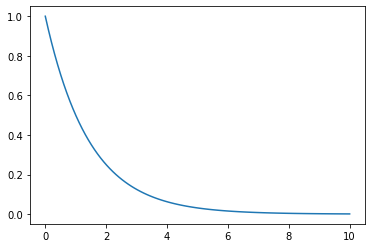

In [117]:
x = np.linspace(0,10, 100)
y = 1 / (2 ** x)
plt.plot(x,y)
# plt.yscale('log')